In [1]:
# Jon's notebook

# remember to add non-visual graphics

In [2]:
# Contents with hyperlinks within document?

# Overview

- business / data understanding - what kind of data are you using? and what makes it well-suited for the business problem
- data prep - why did you choose the data prep steps that you did? and what was the result
- modeling - what modeling packages did you use, which models within the packages, and what tuning steps did you take?
- evaluation - How well did your model perform? Relevant metrics. Validation approach

# Business and Data Understanding

what kind of data are you using? and what makes it well-suited for the business problem

# Data Preparation 

feature engineering, using pipelines or using unsupervised techniques

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NMF, BaselineOnly, NormalPredictor 

import pickle

## Loading in data files

### Links from MovieLens to IMDB and TMDB

- for IMDB: https://www.imdb.com/tt then movie id
- for TMDB: https://www.themoviedb.org/movie/ then movie id

In [4]:
links = pd.read_csv('data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [6]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

### Movie IDs with Title and Genres

only movies with at least one rating or tag are included, per MovieLens

Movie IDs are consistent across all four data files, and correspond with the __[MovieLens.org/movies/](https://movielens.org/movies/)__ URL

Genres are a pipe-separated list selected from the following:
- Action
- Adventure
- Animation
- Children's
- Comedy
- Crime
- Documentary
- Drama
- Fantasy
- Film-Noir
- Horror
- Musical
- Mystery
- Romance
- Sci-Fi
- Thriller
- War
- Western
- (no genres listed)

In [7]:
movies = pd.read_csv('data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

### User Ratings (min. 20 per userid)

user id is the same with tags.csv below too

Users are selected for inclusion at random per MovieLens

Ratings are made on a 5 star scale, with half-star increments (0.5 - 5.0)

In [10]:
ratings = pd.read_csv('data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [12]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### Tags provided by user

Tags are "user-generated metadata about movies...typically a single word or short phrase"

Timestamp represents seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970

In [13]:
tags = pd.read_csv('data/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [14]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [15]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

## Combined dataframe with movies and ratings

In [16]:
df = pd.merge(movies, ratings, on='movieId')
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [17]:
len(df)

100836

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [19]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [20]:
df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


# Modeling

- Rationale, results, limitations & recommendations
- Multiple different packages & model explainability tools

In [21]:
# start with dummy / simple model
# then clear explanation why you went from one model to the next
# cross val scores
# why is this going to help your model?

# limitations: cold start.  At least talk about.  Maybe hybrid model
# with content-based filtering to start?

## Surprise Data and train/test split

In [59]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

In [60]:
# train/test split at 80/20

trainset, testset = train_test_split(data, test_size=0.2, random_state=24)


In [61]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')
print('Number of ratings: ', trainset.n_ratings, '\n')

Number of users:  610 

Number of items:  8961 

Number of ratings:  80668 



In [62]:
# confirming 80% trainset

(trainset.n_ratings) / len(df)

0.7999920663255187

## Baseline Simple Model - Random Rating

The NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.

In [63]:
# from Daniel

# Instantiate and fit model
baseline = NormalPredictor()
baseline.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline.test(testset)

# Save RMSE score to variable
baseline_normal = accuracy.rmse(predictions)

RMSE: 1.4453


In [76]:
cross_validate(baseline, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.4299  1.4365  1.4196  1.4287  0.0070  
Fit time          0.08    0.07    0.07    0.07    0.00    
Test time         0.19    0.17    0.14    0.17    0.02    


{'test_rmse': array([1.42989726, 1.4365189 , 1.41955178]),
 'fit_time': (0.07726168632507324, 0.06971502304077148, 0.07277369499206543),
 'test_time': (0.19051384925842285, 0.16570210456848145, 0.1417090892791748)}

## Baseline Simple Model - Baseline Estimate

In [64]:
# from Daniel

# Instantiate and fit model
baseline2 = BaselineOnly()
baseline2.fit(trainset)

# Return test predictions for model fit on trainset
predictions = baseline2.test(testset)

# Save RMSE score to variable
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8771


In [77]:
cross_validate(baseline2, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8713  0.8796  0.8782  0.8764  0.0036  
Fit time          0.06    0.06    0.06    0.06    0.00    
Test time         0.18    0.20    0.18    0.19    0.01    


{'test_rmse': array([0.87131121, 0.87962193, 0.87823681]),
 'fit_time': (0.058912038803100586, 0.0597844123840332, 0.05725979804992676),
 'test_time': (0.18312788009643555, 0.19510579109191895, 0.1844465732574463)}

## SVD and Cross-validating a Simple Model

In [65]:
# Funk's SVD, no hyperparameters

svd_basic = SVD(random_state=24)
cross_validate(svd_basic, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8835  0.8775  0.8840  0.8817  0.0030  
Fit time          2.74    2.74    2.69    2.72    0.03    
Test time         0.18    0.18    0.21    0.19    0.02    


{'test_rmse': array([0.88354634, 0.87745975, 0.88399134]),
 'fit_time': (2.7406504154205322, 2.7445478439331055, 2.6875452995300293),
 'test_time': (0.18360567092895508, 0.17983579635620117, 0.2140958309173584)}

In [66]:
# from Daniel

# Fit to trainset and predict on the testset for evaluation
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)
svd_simple = accuracy.rmse(predictions)

RMSE: 0.8767


In [ ]:
# svd_simple = SVD(verbose=True, n_epochs=10)
# cross_validate(svd_simple, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

In [ ]:
# Canvas - 

# trainset, testset = train_test_split(jokes, test_size=0.2)

In [ ]:
# print(len(testset))

## GridSearchCV

In [67]:
# from Canvas


# dictionary of hyperparameters
svd_param_grid = {'n_factors':[20, 50, 100],
                  'n_epochs': [5, 10], 
                  'lr_all': [0.002, 0.005, 0.05],
                  'reg_all': [0.01, 0.1, 0.5],
                 'biased': [True, False]}
# instantiate
svd_gs_model = GridSearchCV(SVD,param_grid=svd_param_grid,measures=['rmse'],n_jobs = -2,joblib_verbose=5)

# model is fit and best_params scored by RMSE
svd_gs_model.fit(data)
svd_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-2)]: Done 266 tasks      | elapsed:   46.4s
[Parallel(n_jobs=-2)]: Done 428 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 540 out of 540 | elapsed:  2.5min finished


{'n_factors': 100,
 'n_epochs': 10,
 'lr_all': 0.05,
 'reg_all': 0.1,
 'biased': True}

In [75]:
svd = SVD(n_factors=100, n_epochs=10, lr_all=0.05, reg_all=0.1, biased=True)
svd.fit(trainset)
predictions = svd.test(testset)
svd_gs1 = accuracy.rmse(predictions)

RMSE: 0.8627


In [69]:
cross_validate(svd, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8605  0.8698  0.8721  0.8675  0.0050  
Fit time          1.78    1.77    1.83    1.79    0.02    
Test time         0.27    0.27    0.27    0.27    0.00    


{'test_rmse': array([0.86045403, 0.86976454, 0.87213541]),
 'fit_time': (1.7806003093719482, 1.7697906494140625, 1.8259310722351074),
 'test_time': (0.27420663833618164, 0.2665698528289795, 0.26934051513671875)}

In [ ]:
# Can put in multiple GridSearches here, with rational for tweaks

## Non-negative Matrix Factorization

A collaborative filtering algorithm based on Non-negative Matrix Factorization.

This algorithm is very similar to SVD. The user and item factors are kept positive.

The optimization procedure is a (regularized) stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

In [70]:
# from Daniel.  Says keep n_factors low to minimize bias

# New hyperparameter dictionary for nmf model
nmf_param_grid = {'biased':[True, False],
                  'n_factors':[1, 5, 10],
                  'n_epochs': [25, 50]}
nmf_gs_model = GridSearchCV(NMF, param_grid=nmf_param_grid, measures=['rmse'], cv=3, joblib_verbose=10, n_jobs=-2, return_train_measures=True)

# Fit and return the best hyperparameters
nmf_gs_model.fit(data)
nmf_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done  19 out of  36 | elapsed:   10.8s remaining:    9.7s
[Parallel(n_jobs=-2)]: Done  23 out of  36 | elapsed:   11.7s remaining:    6.6s
[Parallel(n_jobs=-2)]: Done  27 out of  36 | elapsed:   12.3s remaining:    4.0s
[Parallel(n_jobs=-2)]: Done  31 out of  36 | elapsed:   15.7s remaining:    2.4s
[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed:   18.3s finished


{'biased': True, 'n_factors': 1, 'n_epochs': 50}

In [71]:
# from Daniel

# Instantiate - fit on trainset - score the model on testset
nmf_model = NMF(n_factors=1, n_epochs=50, random_state=24, biased=True)
nmf_model.fit(trainset)
predictions = nmf_model.test(testset)
nmf_gs = accuracy.rmse(predictions)

RMSE: 0.8753


In [72]:
cross_validate(nmf_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8788  0.8785  0.8746  0.8773  0.0019  
Fit time          2.26    2.26    2.24    2.25    0.01    
Test time         0.24    0.27    0.27    0.26    0.01    


{'test_rmse': array([0.87877371, 0.87849235, 0.87461783]),
 'fit_time': (2.2551867961883545, 2.257777690887451, 2.2384138107299805),
 'test_time': (0.24288272857666016, 0.26682090759277344, 0.2744014263153076)}

In [ ]:
# worse than basic SVD and subsequent searches

## SVD++ Model

The SVD++ algorithm, an extension of SVD taking into account implicit ratings

In [73]:
# instantiating default SVDpp

svdpp_default_model = SVDpp()

# Fit and return RMSE
svdpp_default_model.fit(trainset)
predictions = svdpp_default_model.test(testset)
svdpp_default = accuracy.rmse(predictions)

RMSE: 0.8646


In [78]:
cross_validate(svdpp_default_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8712  0.8689  0.8707  0.8703  0.0010  
Fit time          415.21  417.51  416.03  416.25  0.95    
Test time         12.67   11.92   12.30   12.29   0.31    


{'test_rmse': array([0.87119742, 0.86889475, 0.87071162]),
 'fit_time': (415.2051718235016, 417.51220321655273, 416.03457522392273),
 'test_time': (12.66629147529602, 11.915123462677002, 12.298882961273193)}

In [79]:
# from Daniel

# New dictionary for SVD++
svdpp_param_grid = {'n_factors':[5, 10],
                    'n_epochs':[25, 50],
                    'reg_all':[0.02, 0.05]}
svdpp_gs_model = GridSearchCV(SVDpp, param_grid=svdpp_param_grid, cv=3, joblib_verbose=10, n_jobs=-2, return_train_measures=True)

# Fit and return the best_params based on cross validation.  This will take awhile (about 1 hour??!) - was faster earlier in the day
svdpp_gs_model.fit(data)
svdpp_gs_model.best_params['rmse']

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-2)]: Done   6 out of  24 | elapsed: 11.8min remaining: 35.3min
[Parallel(n_jobs=-2)]: Done   9 out of  24 | elapsed: 24.9min remaining: 41.4min
[Parallel(n_jobs=-2)]: Done  12 out of  24 | elapsed: 32.4min remaining: 32.4min
[Parallel(n_jobs=-2)]: Done  15 out of  24 | elapsed: 32.7min remaining: 19.6min
[Parallel(n_jobs=-2)]: Done  18 out of  24 | elapsed: 43.6min remaining: 14.5min
[Parallel(n_jobs=-2)]: Done  21 out of  24 | elapsed: 56.0min remaining:  8.0min
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 57.8min remaining:    0.0s
[Parallel(n_jobs=-2)]: Done  24 out of  24 | elapsed: 57.8min finished


{'n_factors': 5, 'n_epochs': 25, 'reg_all': 0.05}

In [80]:
# Instantiate - fit on trainset - score the model on testset
svdpp_model = SVDpp(n_factors=5, n_epochs=25, random_state=24, reg_all=0.05)
svdpp_model.fit(trainset)
predictions = svdpp_model.test(testset)
svdpp_gs = accuracy.rmse(predictions)

RMSE: 0.8644


In [81]:
cross_validate(svdpp_model, data, measures=['RMSE'], cv=3, n_jobs=-2, verbose=True)

Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8631  0.8684  0.8700  0.8672  0.0029  
Fit time          314.62  317.83  317.44  316.63  1.43    
Test time         13.46   12.62   12.85   12.98   0.35    


{'test_rmse': array([0.86311568, 0.86838435, 0.86997695]),
 'fit_time': (314.6210181713104, 317.833749294281, 317.44257736206055),
 'test_time': (13.458080291748047, 12.624501705169678, 12.852906465530396)}

# Model Evaluation

## Initial Visuals

In [82]:
X = ['Random', 'Baseline Only', 'SVD Simple', 'SVD GS1', 'NMF GS', 'SVDpp default', 'SVDpp GS']
y = [baseline_normal, baseline_only, svd_simple, svd_gs1, nmf_gs, svdpp_default, svdpp_gs]

Text(0, 0.5, 'Root Mean Squared Error (RMSE)')

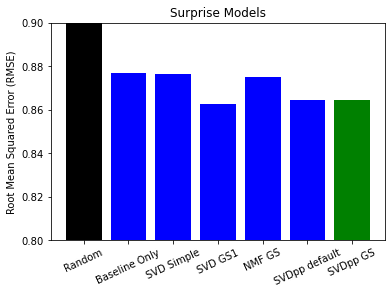

In [85]:
fig, ax = plt.subplots()
plt.bar(X, y, color=['black', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xticks(rotation=25)
plt.ylim(0.8, .9)
plt.grid(False)
ax.set_title("Surprise Models")
plt.ylabel('Root Mean Squared Error (RMSE)')
# plt.savefig('Images/Model_bar.png', dpi=300, bbox_inches='tight');

## Recommendation Function

In [ ]:
# towards Data Science blog

final_model_train = data.build_full_trainset()
svdpp_gs_model.fit(final_model_train)

In [ ]:
# movieid, title, genre

# then drop_duplicates['movieId']

In [56]:
df['predicted_rating'] = df['movieId'].apply(lambda x: svdpp_model.predict(2, x).est)
df.sort_values(by='predicted_rating', ascending=False, inplace=True)
df.head()

,movieId,title,genres,userId,rating,timestamp,predicted_rating
2012,43,Restoration (1995),Drama,521,4.0,852713446,5.0
2006,43,Restoration (1995),Drama,6,4.0,845555607,5.0
2007,43,Restoration (1995),Drama,33,2.0,939716739,5.0
2008,43,Restoration (1995),Drama,288,3.0,976122034,5.0
2009,43,Restoration (1995),Drama,437,3.0,859721556,5.0


In [58]:
df['movieId'].nunique()

9724

In [ ]:
#  need to drop movies they've already watched.  before or after .apply.  
# recommends doing before

In [ ]:
# generating rating predictions

# svd.predict(uid=10, iid=100)

In [ ]:
# Returns:

# Prediction(uid=10, iid=100, r_ui=None, est=4.051206489275292, details={'was_impossible': False})

In [ ]:
# import difflib
# import random

# def get_book_id(book_title, metadata):
    
#     """
#     Gets the book ID for a book title based on the closest match in the metadata dataframe.
#     """
    
#     existing_titles = list(metadata['title'].values)
#     closest_titles = difflib.get_close_matches(book_title, existing_titles)
#     book_id = metadata[metadata['title'] == closest_titles[0]]['id'].values[0]
#     return book_id

# def get_book_info(book_id, metadata):
    
#     """
#     Returns some basic information about a book given the book id and the metadata dataframe.
#     """
    
#     book_info = metadata[metadata['id'] == book_id][['id', 'isbn', 
#                                                     'authors', 'title', 'original_title']]
#     return book_info.to_dict(orient='records')

# def predict_review(user_id, book_title, model, metadata):
    
#     """
#     Predicts the review (on a scale of 1-5) that a user would assign to a specific book. 
#     """
    
#     book_id = get_book_id(book_title, metadata)
#     review_prediction = model.predict(uid=user_id, iid=book_id)
#     return review_prediction.est

# def generate_recommendation(user_id, model, metadata, thresh=4):
    
#     """
#     Generates a book recommendation for a user based on a rating threshold. Only
#     books with a predicted rating at or above the threshold will be recommended
#     """
    
#     book_titles = list(metadata['title'].values)
#     random.shuffle(book_titles)
    
#     for book_title in book_titles:
#         rating = predict_review(user_id, book_title, model, metadata)
#         if rating >= thresh:
#             book_id = get_book_id(book_title, metadata)
#             return get_book_info(book_id, metadata)

In [ ]:
# code for 2D visualization of multi-dimensional recommendation (scatter plot)
# towards data science post

# Evaluation